In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -qU ultralytics supervision

In [4]:
!pip install ultralytics --upgrade


In [5]:
import ultralytics
ultralytics.checks()


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.6/107.7 GB disk)


In [6]:
!pip install ultralytics roboflow supervision


In [7]:
from roboflow import Roboflow

rf = Roboflow(api_key="wraQ5Z8NaxoKsxyt9TFm")
project = rf.workspace("ayu-asipq").project("calory")
dataset = project.version(1).download("yolov11")


loading Roboflow workspace...
loading Roboflow project...


TRAINING YOLOv11

In [8]:
!ls /content


Calory-1  drive  runs  yolo11n.pt


In [10]:
import torch
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cpu


In [13]:
# ==============================
# Setup environment dan load model YOLO
# ==============================
import torch
from ultralytics import YOLO

# ==============================
# Tentukan device otomatis: GPU jika ada, CPU jika tidak
# ==============================
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ==============================
# Safe globals untuk mencegah UnpicklingError
# ==============================
torch.serialization.add_safe_globals([torch.nn.modules.container.Sequential])

# ==============================
# Load model YOLO
# ==============================
model_path = '/content/drive/MyDrive/Capstone 4/yolo11n.pt'  # sesuaikan path
model = YOLO(model_path)
print("✅ Model YOLO berhasil dimuat!")

# ==============================
# Training model (dioptimalkan untuk CPU / Colab gratis)
# ==============================
# Tips optimasi:
# - Kurangi ukuran gambar: 416 → lebih ringan
# - Kurangi batch size: 4-8 → lebih aman di CPU
# - Kurangi epoch jika hanya testing
model.train(
    data="/content/Calory-1/data.yaml",   # sesuaikan path YAML
    epochs=20,      # turunkan epoch untuk mempercepat
    imgsz=416,      # turunkan ukuran gambar
    batch=4,        # batch kecil supaya tidak berat di CPU
    patience=10,
    pretrained=True,
    device=device   # otomatis GPU/CPU
)

print("✅ Training selesai!")


Using device: cpu
✅ Model YOLO berhasil dimuat!
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Calory-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Capstone 4/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, o

In [26]:
!find /content/runs/detect -name "best.pt"


/content/runs/detect/train3/weights/best.pt


In [27]:
!cp /content/runs/train/exp/best.pt /content/drive/MyDrive/


cp: cannot stat '/content/runs/train/exp/best.pt': No such file or directory


In [28]:
!pip install -qU ultralytics supervision

In [17]:
import cv2
import supervision as sv
from ultralytics import YOLO

In [24]:
import glob

weights_files = glob.glob("/content/runs/train/**/*.pt", recursive=True)
print(weights_files)


[]


In [29]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train3/weights/best.pt")


In [30]:
calorie_info = {
    "Ayam Goreng": "260 kal / 100 g",
    "Capcay": "67 kal / 100 g",
    "Nasi": "129 kal / 100 g",
    "Sayur Bayam": "36 kal / 100 g",
    "Sayur Kangkung": "98 kal / 100 g",
    "Sayur Sop": "22 kal / 100 g",
    "Tahu": "80 kal / 100 g",
    "Telur Dadar": "93 kal / 100 g",
    "Telur Mata Sapi": "110 kal / 1 butir",
    "Telur Rebus": "78 kal / 1 butir",
    "Tempe": "225 kal / 100 g",
    "Tumis Buncis": "65 kal / 100 g",
    "food-z7P4": "-"
}


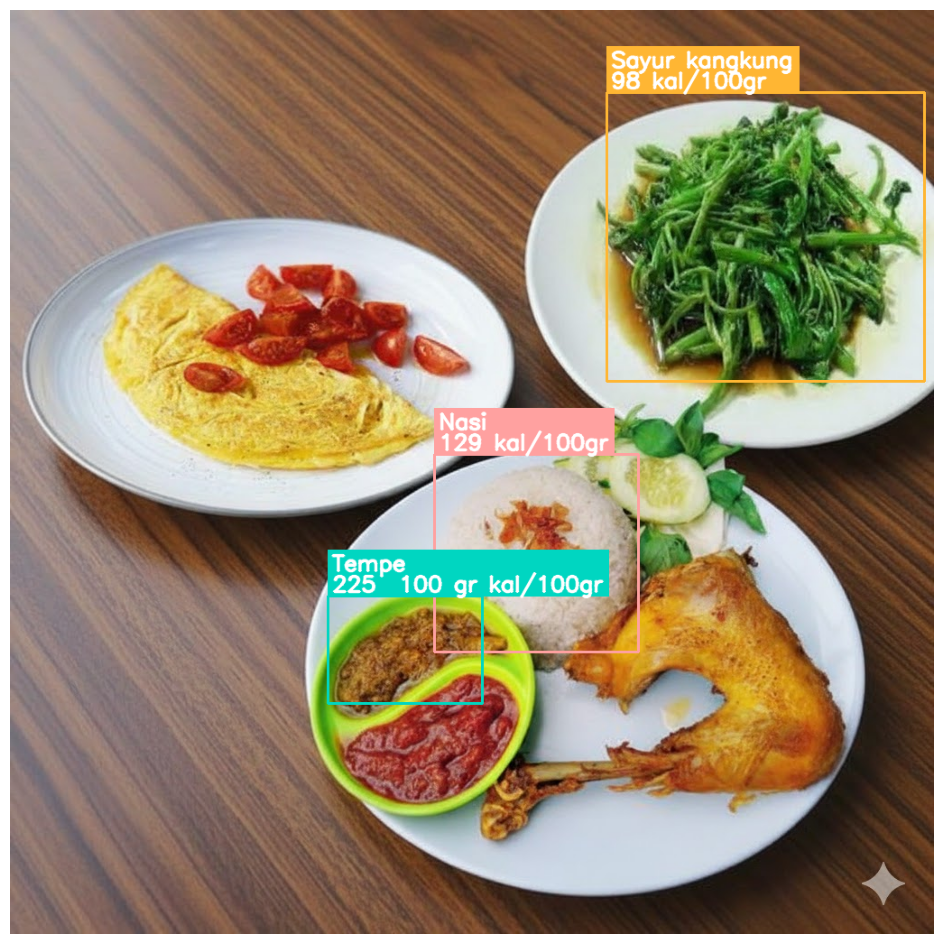

Detections(xyxy=array([[     661.22,      91.619,      1013.4,      411.08],
       [     470.03,         492,      696.49,      711.76],
       [     352.97,      649.18,      523.55,         769]], dtype=float32), mask=None, confidence=array([    0.52886,     0.39377,     0.29565], dtype=float32), class_id=array([ 4,  2, 10]), tracker_id=None, data={'class_name': array(['Sayur kangkung -98 kal per 100gr-', 'Nasi -129 kal per 100gr-', 'Tempe -225 kal per 100 gr-'], dtype='<U33')}, metadata={})

In [31]:
image = cv2.imread('/content/drive/MyDrive/Capstone 4/test_food.jpg')

# Inference
results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# Annotators
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(
    text_scale=0.8,
    text_thickness=2,
    text_padding=5
)

# ------------ FORMAT LABEL PER BARIS -------------
labels = []
for class_id in detections.class_id:
    raw_name = model.names[int(class_id)]  # contoh: "Nasi -129 kal per 100gr-"

    # Pisahkan 2 bagian (nama & kalori)
    parts = raw_name.split("-")
    food_name = parts[0].strip()                   # "Nasi"
    calorie_raw = parts[1].replace("kal per", "").replace("100gr", "").strip()

    # Format lebih rapi → "129 kal/100gr"
    calorie_clean = f"{calorie_raw} kal/100gr"

    # Gabungkan jadi 2 baris
    label = f"{food_name}\n{calorie_clean}"
    labels.append(label)
# --------------------------------------------------

# Draw annotation
annotated_image = box_annotator.annotate(
    scene=image.copy(),
    detections=detections
)

annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

sv.plot_image(annotated_image)

detections


In [32]:
detections

Detections(xyxy=array([[     661.22,      91.619,      1013.4,      411.08],
       [     470.03,         492,      696.49,      711.76],
       [     352.97,      649.18,      523.55,         769]], dtype=float32), mask=None, confidence=array([    0.52886,     0.39377,     0.29565], dtype=float32), class_id=array([ 4,  2, 10]), tracker_id=None, data={'class_name': array(['Sayur kangkung -98 kal per 100gr-', 'Nasi -129 kal per 100gr-', 'Tempe -225 kal per 100 gr-'], dtype='<U33')}, metadata={})